# Calibration

Elements of Data Science

by [Allen Downey](https://allendowney.com)

[MIT License](https://opensource.org/licenses/MIT)

### Goals

In the previous notebook...

The primary goal of this notebook is to review ways to evaluate binary classification algorithms.  We'll start with the confusion matrix and the metrics that are derived from it, including accuracy, sensitivity, specificity, predictive value, false positive rate, and false negative rate.

In this notebook...

Here are the libraries and functions I'll use for my analysis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def decorate(**options):
    """Decorate the current axes.
    
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
             
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    plt.gca().set(**options)
    plt.tight_layout()

In [3]:
def values(series):
    """Count the values and sort.
    
    series: pd.Series
    
    returns: series mapping from values to frequencies
    """
    return series.value_counts(dropna=False).sort_index()

## Data

[This repository](https://github.com/propublica/compas-analysis) the data and analysis pipeline described on [this web page](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm).

The terms of use for the data [are here](https://www.propublica.org/datastore/terms).  In compliance with those terms, I am not redistributing the data.

The following cell downloads the data file we'll use directly from their repository.

In [4]:
import os

if not os.path.exists('compas-scores-two-years.csv'):
    !wget https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv

The following cell read the data file:

In [5]:
cp = pd.read_csv("compas-scores-two-years.csv")
cp.shape

(7214, 53)

The dataset includes 7214 rows, one for each defendant, and 53 columns.

## Code

The following are functions from the previous notebook we will need again.

In [6]:
def make_matrix(cp, subgroup, threshold=4):
    """Make a confusion matrix.
    
    cp: DataFrame
    subgroup: Boolean Series
    
    returns: DataFrame containing the confusion matrix
    """
    a = np.where(cp['decile_score'] > threshold, 
                 'Positive', 
                 'Negative')
    high_risk = pd.Series(a, name='Predicted')
    
    a = np.where(cp['two_year_recid'] == 1, 
                 'Condition', 
                 'No Condition')
    new_charge_2 = pd.Series(a, name='Actual')

    matrix = pd.crosstab(high_risk[subgroup], new_charge_2[subgroup])
    matrix.sort_index(axis=0, ascending=False, inplace=True)
    
    return matrix

In [7]:
def percent(x, y):
    """Compute the percentage `x/(x+y)*100`.
    """
    return x / (x+y) * 100

In [8]:
def predictive_value(m):
    """Compute positive and negative predictive value.
    
    m: confusion matrix
    """
    tp, fp, fn, tn = m.to_numpy().flatten()
    ppv = percent(tp, fp)
    npv = percent(tn, fn)
    return ppv, npv

In [9]:
def sens_spec(m):
    """Compute sensitivity and specificity.
    
    m: confusion matrix
    """
    tp, fp, fn, tn = m.to_numpy().flatten()
    sens = percent(tp, fn)
    spec = percent(tn, fp)
    return sens, spec

In [10]:
def error_rates(m):
    """Compute false positive and false negative rate.
    
    m: confusion matrix
    """
    tp, fp, fn, tn = m.to_numpy().flatten()
    fpr = percent(fp, tn)
    fnr = percent(fn, tp)
    return fpr, fnr

In [11]:
def prevalence(df):
    """Compute prevalence.
    
    m: confusion matrix
    """
    tp, fp, fn, tn = df.to_numpy().flatten()
    prevalence = percent(tp+fn, tn+fp)
    return prevalence

In [12]:
def compute_metrics(m, name=''):
    """Compute all metrics.
    
    m: confusion matrix
    
    returns: DataFrame
    """
    fpr, fnr = error_rates(m)
    ppv, npv = predictive_value(m)
    prev = prevalence(m)
    
    index = ['FP rate', 'FN rate', 'PPV', 'NPV', 'Prevalence']
    df = pd.DataFrame(index=index, columns=['Percent'])
    df.Percent = fpr, fnr, ppv, npv, prev
    df.index.name = name
    return df

## The WaPo response

After the ProPublica article, the Washington Post (WaPo) published a response by Sam Corbett-Davies, Emma Pierson, Avi Feller and Sharad Goel: "[A computer program used for bail and sentencing decisions was labeled biased against blacks. It’s actually not that clear.](https://www.washingtonpost.com/news/monkey-cage/wp/2016/10/17/can-an-algorithm-be-racist-our-analysis-is-more-cautious-than-propublicas/)"

The WaPo article summarizes the ProPublica article and the response from Northpointe, the company that makes COMPAS.  

* ProPublica claims that COMPAS is unfair because "among defendants who ultimately did not reoffend, blacks were more than twice as likely as whites to be classified as medium or high risk."

* Northpoint claims that COMPAS is fair because "scores mean essentially the same thing regardless of the defendant’s race. For example, among defendants who scored a seven on the COMPAS scale, 60 percent of white defendants reoffended, which is nearly identical to the 61 percent of black defendants who reoffended."

So ProPublica and Northpoint are invoking different definitions of "fair".

In the previous notebook we explored the first definition of "fair" by computing error rates (false positive and false negative) for white and black defendants.

In this notebook, we'll explore the second definition, which is called "calibration".

## Calibration

The WaPo article includes this figure, which shows "white and black defendants with the same risk score are roughly equally likely to reoffend."

<img width=90%, src='https://raw.githubusercontent.com/AllenDowney/ElementsOfDataScience/master/calibration1.png'>

To understand this figure, let's start by replicating it.

The following function groups defendants by decile score and computes recidivism rate in each group.

In [13]:
def calibration_curve(df):
    """Compute probability of recidivism by decile score.
    
    df: DataFrame
    
    returns: Series
    """
    grouped = df.groupby('decile_score')
    return grouped['two_year_recid'].mean()

The following figure shows this calibration curve for all defendants and broken down by race.

In [14]:
white = (cp['race'] == 'Caucasian')
white.name = 'white'
values(white)

False    4760
True     2454
Name: white, dtype: int64

In [15]:
black = (cp['race'] == 'African-American')
black.name = 'black'
values(black)

False    3518
True     3696
Name: black, dtype: int64

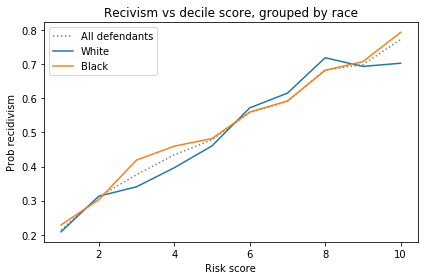

In [16]:
cal_all = calibration_curve(cp)
cal_all.plot(linestyle='dotted', 
              color='gray',
              label='All defendants')

cal_white = calibration_curve(cp[white])
cal_white.plot(label='White')

cal_white = calibration_curve(cp[black])
cal_white.plot(label='Black')

decorate(xlabel='Risk score',
         ylabel='Prob recidivism',
         title='Recivism vs decile score, grouped by race')
plt.legend();

This figure shows that people with higher scores have higher probabilities of recidivism.  In that sense COMPAS works as intended; people with higher risk scores are substantially more likely to be arrested again.

Furthermore, the test is equally calibrated for black and white defendants; in each risk group, the probability of recidivism is about the same for black and white defendants.

The WaPo article explains why this is important:

> A risk score of seven for black defendants should mean the same thing as a score of seven for white defendants. Imagine if that were not so, and we systematically assigned whites higher risk scores than equally risky black defendants with the goal of mitigating ProPublica’s criticism. We would consider that a violation of the fundamental tenet of equal treatment.

So we want a test that has the same predictive value for all groups, and we want a test that has the same error rates for all groups.  

But there's the problem: as the WaPo article explains, it is mathematically impossible to be fair, by both definitions, at the same time.

To see why, let's go back to the confusion matrix.

## Matrices and metrics

As we saw in the previous notebook, here are the confusion matrices for white and black defendants.

In [17]:
matrix_white = make_matrix(cp, white)
matrix_white

Actual,Condition,No Condition
Predicted,,
Positive,505,349
Negative,461,1139


In [18]:
matrix_black = make_matrix(cp, black)
matrix_black

Actual,Condition,No Condition
Predicted,,
Positive,1369,805
Negative,532,990


And here are the metrics we computed from the confusion matrices:

In [19]:
metrics_white = compute_metrics(matrix_white, 
                                'White defendants')
metrics_white

,Percent
White defendants,
FP rate,23.454301
FN rate,47.722567
PPV,59.133489
NPV,71.187500
Prevalence,39.364303


In [20]:
metrics_black = compute_metrics(matrix_black, 
                                'Black defendants')
metrics_black

,Percent
Black defendants,
FP rate,44.846797
FN rate,27.985271
PPV,62.971481
NPV,65.045992
Prevalence,51.433983


If we look at the error rates , it seems like COMPAS is biased against black defendants:

* Their false positive rate is higher (45% vs 23%): among people who will not recidivate, black defendants are more likely to be classified high risk.

* Their false negative rate is lower (28% vs 48%): among people who *will* recidivate, black defendants are less likely to be classified low risk.

But if we look at the the predictive values (PPV and NPV) it seems like COMPAS is biased in favor of black defendants:

* Among people in the high risk group, black defendants are more likely to be arrested again (63% vs 59%).

* Among people in the low risk group, black defendants are less likely to "survive" two years without being arrested again (65% vs 71%).

It seems like we should be able to fix these problems, but it turns out that we can't.  

* If we make the error rates more equal, we make the predictive values more unfair, and the other way around; 

* If we make the predictive values more equal, we make the error rates more unfair.

Fundamentally, the problem is that the prevalence of recidivism is different in the two groups: about 39% of white defendants were arrested again, compared to 51% of black defendants.

As long as that's the case (for any two groups) the predictive values and error rates can't be "fair" at the same time.

To see why, consider this: the confusion matrix has four numbers in it, but they have to add up to 100%, so if you give me any three elements of the matrix, I can compute the fourth.

In the same way, if you provide any three (independent) metrics, I can compute the elements of the matrix, and any other metrics.  Specifically:

* Given prevalence, PPV and NPV, we can compute the confusion matrix and the error rates.

* Given prevalence, FPR and FNR, we can compute the confusion matrix and the predictive values.

We could do the algebra by hand, but it is easier (and probably more reliable) to use SymPy.

Here are the symbols we'll use:

In [21]:
from sympy import symbols, Eq, solve

tn, fp, fn, tp = symbols('tn, fp, fn, tp')
ppv, npv, prev = symbols('ppv, npv, prev')
fpr, fnr = symbols('fpr, fnr')

And here are the equations that relate the metrics to the elements of the confusion matrix.

In [22]:
eq1 = Eq(prev, tp+fn)
eq2 = Eq(fpr, fp / (fp+tn))
eq3 = Eq(fnr, fn / (fn+tp))
eq4 = Eq(ppv, tp / (tp+fp))
eq5 = Eq(npv, tn / (tn+fn))
eq6 = Eq(tn+fp+fn+tp, 1)

We can use `solve` to get expressions for the elements of the confusion matrix in terms of `ppv`, `npv`, and `prev`:

In [23]:
soln1 = solve([eq1, eq2, eq3, eq4, eq5, eq6], 
              [tp, fp, fn, tn, fpr, fnr])
soln1[0]

(ppv*(npv + prev - 1)/(npv + ppv - 1),
 -(ppv - 1)*(npv + prev - 1)/(npv + ppv - 1),
 -(npv - 1)*(ppv - prev)/(npv + ppv - 1),
 npv*(ppv - prev)/(npv + ppv - 1),
 (ppv - 1)*(npv + prev - 1)/((prev - 1)*(npv + ppv - 1)),
 -(npv - 1)*(ppv - prev)/(prev*(npv + ppv - 1)))

We can also solve for the elements of the confusion matrix in terms of `fpr`, `fnr`, and `prev`:

In [24]:
soln2 = solve([eq1, eq2, eq3, eq4, eq5, eq6], 
              [tp, fp, fn, tn, ppv, npv])

soln2[0]

(prev*(1 - fnr),
 fpr*(1 - prev),
 fnr*prev,
 (fpr - 1)*(prev - 1),
 prev*(fnr - 1)/(fnr*prev + fpr*prev - fpr - prev),
 (fpr - 1)*(prev - 1)/(fnr*prev + fpr*prev - fpr - prev + 1))

The following function takes `ppv`, `npv`, and `prev` and uses the expressions from `soln1` to compute a confusion matrix with those metrics.

In [25]:
def constant_predictive_value(ppv, npv, prev):
    """Make a confusion matrix with given metrics.
    
    ppv: positive predictive value
    npv: negative predictive value
    prev: prevalence
    
    returns: confusion matrix
    """
    ppv /= 100
    npv /= 100
    prev /= 100
    a = np.array((ppv*(npv + prev - 1)/(npv + ppv - 1),
                -(ppv - 1)*(npv + prev - 1)/(npv + ppv - 1),
                -(npv - 1)*(ppv - prev)/(npv + ppv - 1),
                npv*(ppv - prev)/(npv + ppv - 1)))
    
    return pd.DataFrame(a.reshape((2, 2)))

To test it, I'll use metrics from the confusion matrix for all defendants.

In [26]:
all_defendants = np.ones_like(white)
matrix_all = make_matrix(cp, all_defendants)
metrics_all = compute_metrics(matrix_all, 'All defendants')
metrics_all

,Percent
All defendants,
FP rate,32.349230
FN rate,37.403876
PPV,61.350618
NPV,68.796510
Prevalence,45.065151


I'll extract PPV, NPV, and prevalence.

In [27]:
ppv, npv = predictive_value(matrix_all)
prev = prevalence(matrix_all)

Given those values, we can reconstruct the confusion matrix and compute the metrics again.

In [28]:
matrix = constant_predictive_value(ppv, npv, prev)
metrics_pred = compute_metrics(matrix)
metrics_pred

,Percent
,
FP rate,32.349230
FN rate,37.403876
PPV,61.350618
NPV,68.796510
Prevalence,45.065151


These "predicted metrics" are the same as the actual metrics, except for small errors due to floating-point error.

In [29]:
metrics_pred - metrics_all

,Percent
,
FP rate,0.000000e+00
FN rate,0.000000e+00
PPV,0.000000e+00
NPV,-1.421085e-14
Prevalence,0.000000e+00


So that confirms that we can use PPV, NPV and prevalence to compute FPR and FNR.

Now let's see what happens if we hold PPV and NPV constant, and vary prevalence.  First I'll extract the prevalence of recidivism for black defendants:

In [30]:
prev = metrics_black['Percent']['Prevalence']
prev

51.433982683982684

Using this prevalence, and holding PPV and NPV constant, we can compute error rates:

In [31]:
matrix = constant_predictive_value(ppv, npv, prev)
error_rates(matrix)

(53.40360542740529, 19.955904234916293)

FPR is substantially higher, and FNR substantially lower, compared to the error rates with lower prevalence.

We can do the same analysis for white defendants.

In [32]:
prev = metrics_white['Percent']['Prevalence']

In [33]:
matrix = constant_predictive_value(ppv, npv, prev)
error_rates(matrix)

(17.254472103643895, 57.81054940714234)

When prevalence is lower, the false positive rate is higher and the false negative rate lower.

## The constant predictive value model

To show these effects more clearly, I'll sweep through a range of prevalences, from 30% to 60%, and plot the error rates we get if we hold predictive values constant.

In [34]:
ppv, npv = predictive_value(matrix_all)
prevalences = np.linspace(35, 55, 11)

pred_er = pd.DataFrame(columns=['fpr', 'fnr'])

for prev in prevalences:
    m = constant_predictive_value(ppv, npv, prev)
    pred_er.loc[prev] = error_rates(m)
    
pred_er

,fpr,fnr
35.0,7.488034,77.925569
37.0,11.795671,68.118564
39.0,16.385776,59.317406
41.0,21.287075,51.374897
43.0,26.532324,44.171227
45.0,32.159046,37.607882
47.0,38.210427,31.603121
49.0,44.736425,26.088543
51.0,51.795158,21.006482
53.0,59.454634,16.307973


The following figure shows the error rates we would expect from a test with equal predictive value for all groups, regardless of prevalence.

In [35]:
def plot_cpv_model(pred_er):
    """Plot error rates with constant predictive values.
    
    pred_er: DataFrame of predicted error rates
    """
    pred_er['fpr'].plot(label='Predicted FPR', color='C2')
    pred_er['fnr'].plot(label='Predicted FNR', color='C4')
    decorate(xlabel='Prevalence', ylabel='Percent',
             title='Error rates, constant predictive value')

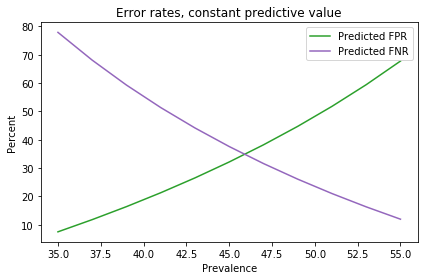

In [36]:
plot_cpv_model(pred_er)
plt.legend();

As prevalence increases, false positive rates increase quickly.  Note the vertical scale: the difference in error rates between a low-prevalence group and a high-prevalence group is dramatic!

For the COMPAS test, the effect is not as extreme.  The following figure shows the constant prediction model again, including data points for the white defendants (left), all defendants (middle), and black defendants (right).

In [37]:
actual_er = pd.DataFrame(columns=['fpr', 'fnr'])

for m in (matrix_white, matrix_all, matrix_black):
    prev = prevalence(m)
    actual_er.loc[prev] = error_rates(m)
    
actual_er

,fpr,fnr
39.364303,23.454301,47.722567
45.065151,32.349230,37.403876
51.433983,44.846797,27.985271


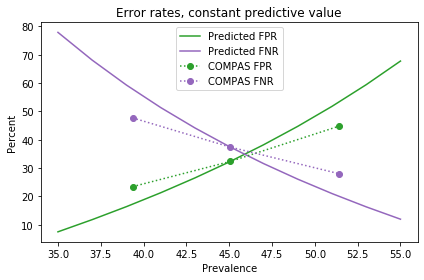

In [38]:
plot_cpv_model(pred_er)

actual_er['fpr'].plot(marker='o', linestyle='dotted', color='C2',
                      label='COMPAS FPR')

actual_er['fnr'].plot(marker='o', linestyle='dotted', color='C4',
                      label='COMPAS FNR')

plt.legend();

For higher-prevalence groups:

* The actual false positive rate is lower that what we would expect if the test had the same predictive value for all groups.

* The actual false negative rate is higher than expected.

For lower-prevalence groups:

* The actual false positive rate is higher than what we would expect if the test had the same predictive value for all groups.

* The actual false negative rate is lower than expected.

Relative to the CPV model, the COMPAS test is what I will call "tempered", that is, less sensitive to variation in prevalence between groups.


## Constant error rate model

In the previous section we held predictive value constant and computed the effect on error rates.  In this section we'll go the other way: if we hold error rates constant for all groups, what effect does that have on predictive value?

The following function takes prevalence and error rates and returns a confusion matrix.



In [39]:
def constant_error_rates(fpr, fnr, prev):
    """Make a confusion matrix with given metrics.
    
    fpr: false positive rate
    fnr: false negative rate
    prev: prevalence
    
    returns: confusion matrix
    """
    prev /= 100
    fpr /= 100
    fnr /= 100
    a = [[prev*(1 - fnr),  fpr*(1 - prev)],
         [fnr*prev,       (fpr - 1)*(prev - 1)]]
    
    return pd.DataFrame(a)

To test it, we can extract metrics for all defendants:

In [40]:
fpr, fnr = error_rates(matrix_all)
prev = prevalence(matrix_all)

And use them to compute the other metrics:

In [41]:
matrix = constant_error_rates(fpr, fnr, prev)
metrics_pred = compute_metrics(matrix)
metrics_pred

,Percent
,
FP rate,32.349230
FN rate,37.403876
PPV,61.350618
NPV,68.796510
Prevalence,45.065151


And use the confusion matrix to compute the other metrics.

In [42]:
metrics_pred - metrics_all

,Percent
,
FP rate,0.000000e+00
FN rate,0.000000e+00
PPV,-7.105427e-15
NPV,1.421085e-14
Prevalence,0.000000e+00


Now we can see how predictive value depends on prevalence (with error rates held constant).

In [43]:
fpr, fnr = error_rates(matrix_all)
prevalences = np.linspace(35, 65, 11)

pred_pv = pd.DataFrame(columns=['ppv', 'npv'])

for prev in prevalences:
    m = constant_error_rates(fpr, fnr, prev)
    pred_pv.loc[prev] = predictive_value(m)
    
pred_pv

,ppv,npv
35.0,51.026704,77.058610
38.0,54.253815,74.689735
41.0,57.350053,72.243048
44.0,60.323222,69.714652
47.0,63.180516,67.100383
50.0,65.928580,64.395791
53.0,68.573560,61.596113
56.0,71.121148,58.696245
59.0,73.576628,55.690711
62.0,75.944906,52.573628


The following function plots the results.

In [44]:
def plot_cer_model(pred_pv):
    """Plot error rates with constant predictive values.
    
    pred_er: DataFrame of predicted error rates
    """
    pred_pv['ppv'].plot(label='Predicted PPV', color='C3')
    pred_pv['npv'].plot(label='Predicted NPV', color='C9')
    decorate(xlabel='Prevalence', ylabel='Percent',
             title='Predictive value, constant error rates')

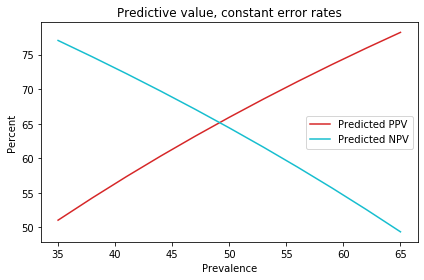

In [45]:
plot_cer_model(pred_pv)
plt.legend();

If we hold error rates constant and increase prevalence, PPV increases and NPV decreases.

For the COMPAS test, the effect is not as extreme.  The following figure shows the constant error rate model again, along with actual predictive values for white defendants (left), all defendants (middle), and black defendants (right).

In [46]:
actual_pv = pd.DataFrame(columns=['ppv', 'npv'])

for m in (matrix_white, matrix_all, matrix_black):
    prev = prevalence(m)
    actual_pv.loc[prev] = predictive_value(m)
    
actual_pv

,ppv,npv
39.364303,59.133489,71.187500
45.065151,61.350618,68.796510
51.433983,62.971481,65.045992


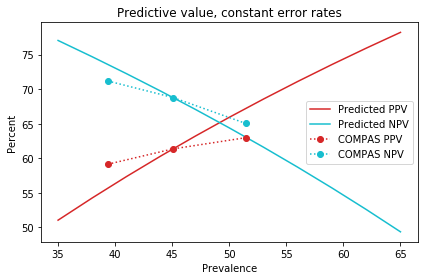

In [47]:
plot_cer_model(pred_pv)

actual_pv['ppv'].plot(marker='o', linestyle='dotted', color='C3',
                      label='COMPAS PPV')

actual_pv['npv'].plot(marker='o', linestyle='dotted', color='C9',
                      label='COMPAS NPV')

plt.legend();

Again, the test is less sensitive to differences in prevalence between groups than we would expect from the constant error rate model.



## Summary

An ideal test should have equal predictive value in all groups; that is, two people with the same risk score should have the same probability of recidivism, regardless of what group they are in.

An ideal test should also have the same error rates for all groups; that is, two non-recidivists should have the same probability of being classified as high risk.

Unfortunately, these two goals are in conflict:

* If you design a test to achieve equal predictive value across groups with different prevalence, you will find that error rates depend on prevalence.  Specifically, false positive rates will be higher in groups with higher rates of recividism.

* If you design a test to achieve equal error rates across groups, you will find that predictive value depends on prevalence.  Specifically, positive predictive value will be lower in groups with lower rates of recidivism.

Our analysis so far suggests that COMPAS was designed to achieve some balance between predictive values and error rates.

In groups with high prevalence:

* FPR is lower than we would expect if the test had the same predictive value in all groups.

* As a result, PPV is lower than we would expect if error rates were the same in all groups.

In summary, this notebook explored two claims reported in the WaPo article:

* COMPAS is calibrated; that it, the risk scores it assigns correspond to the same probability of recidivism for black and white defendants.

* In groups with different prevalence, it is not possible to have the same predictive values and the same error rates.

We found that these claims are substantially correct; additionally, we found that COMPAS achieves some balance between predictive value and error rates, which may or may not be deliberate.



## Calibration for male and female defendants

In a previous section we saw that COMPAS is nearly calibrated for white and black defendants; that is, the risk scores it assigns correspond to the same probability of recidivism in both groups.

As it turns out the same it not true if we group defendants by sex.

First I'll compute Boolean Series that select male and female defendants:

In [48]:
male = (cp['sex'] == 'Male')
male.mean()

0.8066260049902967

In [49]:
female = (cp['sex'] == 'Female')
female.mean()

0.19337399500970334

Next I'll plot calibration curves for these groups:

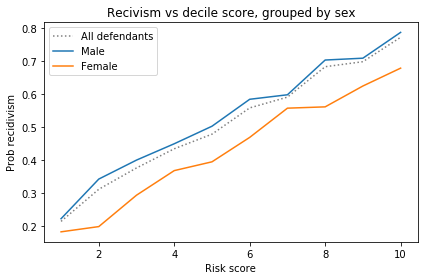

In [50]:
cal_all = calibration_curve(cp)
cal_all.plot(linestyle='dotted', 
              color='gray',
              label='All defendants')

cal_male = calibration_curve(cp[male])
cal_male.plot(label='Male')

cal_female = calibration_curve(cp[female])
cal_female.plot(label='Female')

decorate(xlabel='Risk score',
         ylabel='Prob recidivism',
         title='Recivism vs decile score, grouped by sex')
plt.legend();

For all risk scores, female defendants are substantially less likely to recidivate than male defendants.

Or, reading the graph the other way, female defendants are given decile scores 1-2 points higher than male defendants with the same actual risk of recidivism.

In [51]:
matrix_male = make_matrix(cp, male)
matrix_male

Actual,Condition,No Condition
Predicted,,
Positive,1732,994
Negative,1021,2072


In [52]:
matrix_female = make_matrix(cp, female)
matrix_female

Actual,Condition,No Condition
Predicted,,
Positive,303,288
Negative,195,609


And here are the metrics we computed from the confusion matrices:

In [53]:
metrics_male = compute_metrics(matrix_male, 
                                'Male defendants')
metrics_male

,Percent
Male defendants,
FP rate,32.420091
FN rate,37.086814
PPV,63.536317
NPV,66.989977
Prevalence,47.310534


In [54]:
metrics_female = compute_metrics(matrix_female, 
                                'Female defendants')
metrics_female

,Percent
Female defendants,
FP rate,32.107023
FN rate,39.156627
PPV,51.269036
NPV,75.746269
Prevalence,35.698925


The rate of recidivism (prevalence) is substantially higher for male defendants.

Nevertheless, the error rates for the two groups are about the same.

As a result, the predictive values for the two groups are substantially different:

* PPV: Women classified as high risk are less likely to be arrested again, compared to high-risk men (51% vs 64%).

* NPV: Women classified as low risk are more likely to "survive" two years without arrest, compared to low-risk men (76% vs 67%).

To the degree that COMPAS scores are used to decide which defendants are incarcerated, those decisions 

* Are unfair to women.

* Are less effective than they could be, if they incarcerate lower-risk women while allowing higher-risk men to go free.

## AUC

From [How We Analyzed the COMPAS Recidivism Algorithm](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm)

> Both results are lower than what Northpointe describes as a threshold for reliability. “A rule of thumb according to several recent articles is that AUCs of .70 or above typically indicate satisfactory predictive accuracy, and measures between .60 and .70 suggest low to moderate predictive accuracy,” the company says in its study.

## ROC

One way to do that is to adjust the threshold so the error rates are the same in both groups.

The following function loops through the possible threshold for the low and high risk groups.  For each threshold, it makes the confusion matrix and computes sensitivity and specificity.

In [55]:
thresholds = range(1, 10)
for threshold in thresholds:
    matrix = make_matrix(cp, white, threshold)
    t = sens_spec(matrix)
    print(threshold, t)

1 (85.30020703933747, 36.223118279569896)
2 (73.6024844720497, 52.88978494623656)
3 (63.975155279503106, 64.98655913978494)
4 (52.27743271221532, 76.54569892473118)
5 (40.78674948240166, 85.28225806451613)
6 (29.296066252587995, 90.86021505376344)
7 (20.18633540372671, 94.55645161290323)
8 (11.697722567287784, 96.70698924731182)
9 (4.658385093167702, 98.72311827956989)


When the threshold is low, almost everyone is in the high risk group; in that case:

* Sensitivity is high because most recidivists are in the high risk group, but 

* Specificity is low because most non-recidivists are *also* in the high risk group.

When the threshold is high, almost everyone is in the low risk group, and the metrics are the other way around:

* Sensitivity is low because most recidivists are in the low risk group, but

* Specificity is high because most non-recidivists are *also* in the low risk group.

One way to visualize these results is to plot sensitivity versus FPR (which is the complement of specificity) for a range of thresholds.  For historical reasons, the result is called a [receiver operating characteristic (ROC) curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic).

The following function computes the ROC curve for a given subset of the data:

In [56]:
def make_roc(cp, group):

    thresholds = range(1, 10)
    roc = pd.DataFrame(index=thresholds, 
                   columns=['sens', 'spec'])

    for threshold in thresholds:
        matrix = make_matrix(cp, group, threshold)
        roc.loc[threshold] = sens_spec(matrix)
    
    roc['fpr'] = 100 - roc['spec']
    
    return roc

In [57]:
roc_white = make_roc(cp, white)
roc_white

,sens,spec,fpr
1,85.3002,36.2231,63.7769
2,73.6025,52.8898,47.1102
3,63.9752,64.9866,35.0134
4,52.2774,76.5457,23.4543
5,40.7867,85.2823,14.7177
6,29.2961,90.8602,9.13978
7,20.1863,94.5565,5.44355
8,11.6977,96.707,3.29301
9,4.65839,98.7231,1.27688


In [58]:
roc_black = make_roc(cp, black)
roc_black

,sens,spec,fpr
1,95.213,17.1031,82.8969
2,88.9532,32.3677,67.6323
3,81.3256,43.5655,56.4345
4,72.0147,55.1532,44.8468
5,62.7564,65.6825,34.3175
6,51.4466,75.0975,24.9025
7,38.9795,84.1783,15.8217
8,26.0915,90.5292,9.47075
9,11.9411,96.7131,3.28691


In [59]:
def plot_roc(roc):
    plt.plot(roc['fpr'], roc['sens'])

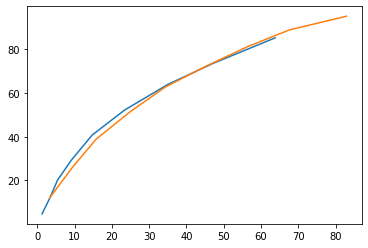

In [60]:
plot_roc(roc_white)
plot_roc(roc_black)